# 🧹 Preprocessing and Baseline Models
## Halal-Haram Food Detection Project

**Tujuan Notebook**: Membersihkan data, membuat dataset split yang definitif, dan membuat model baseline (non-Deep Learning) sebagai pembanding untuk model deep learning.

**Output yang Diharapkan**:
- Dataset split (train/validation/test) yang konsisten
- Text preprocessing pipeline yang optimal
- Model baseline dengan TF-IDF + Machine Learning klasik
- Benchmark performa untuk model deep learning

---

## 1. 📚 Import Libraries
Mengimpor semua library yang diperlukan untuk preprocessing dan modeling.

In [1]:
# Data manipulation dan analisis
import pandas as pd
import numpy as np
import json
import re
import string
from collections import Counter

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Scikit-learn untuk preprocessing dan modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Model persistence
import joblib
import pickle

# Download NLTK data jika belum ada
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Konfigurasi visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Semua library berhasil diimpor!")
print(f"🎲 Random state: {RANDOM_STATE}")

✅ Semua library berhasil diimpor!
🎲 Random state: 42


[nltk_data] Downloading package punkt to C:\Users\Muhammad Irfan
[nltk_data]     Karim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Muhammad Irfan
[nltk_data]     Karim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Muhammad Irfan
[nltk_data]     Karim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. 📂 Load Data dan Analysis Summary
Memuat dataset dan hasil analisis dari notebook sebelumnya.

In [2]:
# Load dataset
try:
    df = pd.read_csv('cleaned_dataset.csv')
    print(f"✅ Dataset berhasil dimuat: {df.shape[0]} baris, {df.shape[1]} kolom")
except FileNotFoundError:
    print("❌ File 'cleaned_dataset.csv' tidak ditemukan!")
    raise

# Load analysis summary dari notebook sebelumnya
try:
    with open('data_analysis_summary.json', 'r', encoding='utf-8') as f:
        analysis_summary = json.load(f)
    print("✅ Analysis summary berhasil dimuat dari notebook sebelumnya")
    
    # Extract informasi penting
    label_col = analysis_summary['label_info']['label_column']
    text_col = analysis_summary['text_stats']['text_column']
    recommended_max_length = analysis_summary['text_stats']['recommended_max_length']
    is_balanced = analysis_summary['label_info']['is_balanced']
    
    print(f"📊 Label column: '{label_col}'")
    print(f"📝 Text column: '{text_col}'")
    print(f"📏 Recommended max length: {recommended_max_length} words")
    print(f"⚖️ Dataset balanced: {is_balanced}")
    
except FileNotFoundError:
    print("⚠️ Analysis summary tidak ditemukan, menggunakan default values")
    # Default values jika file tidak ada
    label_col = df.columns[-1]  # Asumsi kolom terakhir adalah label
    text_col = df.columns[0]    # Asumsi kolom pertama adalah text
    recommended_max_length = 100
    is_balanced = True
    
    print(f"📊 Using default - Label column: '{label_col}'")
    print(f"📝 Using default - Text column: '{text_col}'")

# Tampilkan preview data
print("\n🔍 Preview data:")
display(df.head())

print(f"\n📈 Distribusi label:")
print(df[label_col].value_counts())
print(f"\nPersentase:")
print(df[label_col].value_counts(normalize=True) * 100)

✅ Dataset berhasil dimuat: 39787 baris, 2 kolom
✅ Analysis summary berhasil dimuat dari notebook sebelumnya
📊 Label column: 'label'
📝 Text column: 'text'
📏 Recommended max length: 119 words
⚖️ Dataset balanced: True

🔍 Preview data:


,text,label
0,vegetable oil,halal
1,beef stock contains less than of mirepoix carr...,halal
2,clam stock potatoes clams cream vegetable oil ...,haram
3,water cream broccoli celery vegetable oil corn...,haram
4,chicken stock contains less than of yeast extr...,halal



📈 Distribusi label:
label
halal    21826
haram    17961
Name: count, dtype: int64

Persentase:
label
halal    54.857114
haram    45.142886
Name: proportion, dtype: float64


## 3. 🧹 Text Preprocessing
Membuat pipeline preprocessing teks yang komprehensif dan optimal.

🧹 TEXT PREPROCESSING PIPELINE

🧪 Testing preprocessing pipeline:

📝 Sample 1:
  Original: vegetable oil...
  Cleaned:  vegetable oil...
  Length: 2 → 2 words

📝 Sample 2:
  Original: beef stock contains less than of mirepoix carrots celery onions salt natural flavoring yeast extract...
  Cleaned:  beef stock mirepoix carrot celery onion salt yeast extract cane sugar...
  Length: 17 → 11 words

📝 Sample 3:
  Original: clam stock potatoes clams cream vegetable oil corn canola andor soybean celery contains less than of...
  Cleaned:  clam stock potato clam cream vegetable oil corn canola andor soybean celery modified food starch sal...
  Length: 68 → 58 words

🔄 Applying preprocessing to entire dataset...

📊 Preprocessing Statistics:
  Original text - Mean words: 42.13
  Cleaned text - Mean words: 37.03
  Reduction: 12.1%


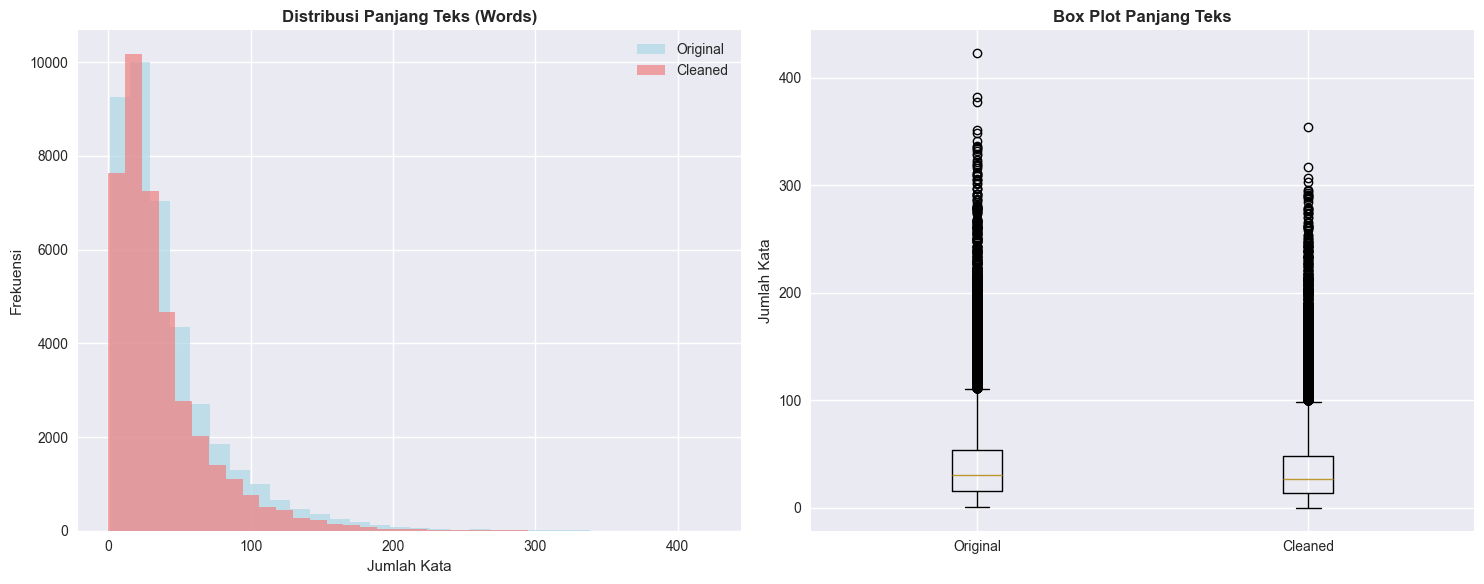


✅ Text preprocessing selesai!


In [3]:
print("🧹 TEXT PREPROCESSING PIPELINE")
print("=" * 50)

# Initialize preprocessing tools
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Tambahkan custom stopwords untuk ingredients
custom_stopwords = {
    'and', 'or', 'with', 'contains', 'may', 'contain', 'less', 'than', 
    'added', 'natural', 'artificial', 'flavor', 'flavoring', 'color', 
    'coloring', 'preservative', 'stabilizer', 'emulsifier'
}
stop_words.update(custom_stopwords)

def clean_text(text, 
               lowercase=True, 
               remove_punctuation=True, 
               remove_numbers=False,
               remove_stopwords=True, 
               apply_stemming=False, 
               apply_lemmatization=True,
               min_word_length=2):
    """
    Comprehensive text cleaning function
    
    Parameters:
    -----------
    text : str
        Input text to clean
    lowercase : bool
        Convert to lowercase
    remove_punctuation : bool
        Remove punctuation marks
    remove_numbers : bool
        Remove numeric characters
    remove_stopwords : bool
        Remove stopwords
    apply_stemming : bool
        Apply stemming (Porter Stemmer)
    apply_lemmatization : bool
        Apply lemmatization
    min_word_length : int
        Minimum word length to keep
    
    Returns:
    --------
    str : Cleaned text
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text)
    if lowercase:
        text = text.lower()
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove numbers if specified
    if remove_numbers:
        text = re.sub(r'\d+', '', text)
    
    # Remove punctuation if specified
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Filter tokens
    filtered_tokens = []
    for token in tokens:
        # Skip if too short
        if len(token) < min_word_length:
            continue
        
        # Skip stopwords if specified
        if remove_stopwords and token in stop_words:
            continue
        
        # Apply stemming or lemmatization
        if apply_stemming:
            token = stemmer.stem(token)
        elif apply_lemmatization:
            token = lemmatizer.lemmatize(token)
        
        filtered_tokens.append(token)
    
    return ' '.join(filtered_tokens)

# Test preprocessing dengan beberapa contoh
print("\n🧪 Testing preprocessing pipeline:")
sample_texts = df[text_col].head(3).tolist()

for i, text in enumerate(sample_texts, 1):
    print(f"\n📝 Sample {i}:")
    print(f"  Original: {text[:100]}...")
    
    cleaned = clean_text(text)
    print(f"  Cleaned:  {cleaned[:100]}...")
    
    print(f"  Length: {len(str(text).split())} → {len(cleaned.split())} words")

# Apply preprocessing ke seluruh dataset
print("\n🔄 Applying preprocessing to entire dataset...")
df['cleaned_text'] = df[text_col].apply(clean_text)

# Statistik setelah preprocessing
original_word_counts = df[text_col].apply(lambda x: len(str(x).split()))
cleaned_word_counts = df['cleaned_text'].apply(lambda x: len(str(x).split()))

print(f"\n📊 Preprocessing Statistics:")
print(f"  Original text - Mean words: {original_word_counts.mean():.2f}")
print(f"  Cleaned text - Mean words: {cleaned_word_counts.mean():.2f}")
print(f"  Reduction: {((original_word_counts.mean() - cleaned_word_counts.mean()) / original_word_counts.mean() * 100):.1f}%")

# Visualisasi perbandingan panjang teks
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(original_word_counts, bins=30, alpha=0.7, label='Original', color='lightblue')
axes[0].hist(cleaned_word_counts, bins=30, alpha=0.7, label='Cleaned', color='lightcoral')
axes[0].set_title('Distribusi Panjang Teks (Words)', fontweight='bold')
axes[0].set_xlabel('Jumlah Kata')
axes[0].set_ylabel('Frekuensi')
axes[0].legend()

axes[1].boxplot([original_word_counts, cleaned_word_counts], labels=['Original', 'Cleaned'])
axes[1].set_title('Box Plot Panjang Teks', fontweight='bold')
axes[1].set_ylabel('Jumlah Kata')

plt.tight_layout()
plt.show()

print("\n✅ Text preprocessing selesai!")

## 4. 📊 Train-Validation-Test Split
Membuat pembagian dataset yang stratified dan konsisten untuk semua eksperimen.

In [4]:
print("📊 TRAIN-VALIDATION-TEST SPLIT")
print("=" * 50)

# Prepare data
X = df['cleaned_text'].values
y = df[label_col].values

# Encode labels jika diperlukan
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(f"📋 Label mapping: {label_mapping}")
print(f"📊 Original label distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count} ({count/len(y)*100:.1f}%)")

# First split: Train + Val (80%) vs Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

# Second split: Train (70% of total) vs Val (10% of total)
# Dari 80% sisanya, bagi menjadi 87.5% train dan 12.5% val
# 87.5% dari 80% = 70% dari total
# 12.5% dari 80% = 10% dari total
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.125,  # 10% dari total / 80% = 0.125
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print(f"\n📈 Dataset split sizes:")
print(f"  Total dataset: {len(X)} samples")
print(f"  Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification
def check_distribution(y_subset, subset_name):
    unique, counts = np.unique(y_subset, return_counts=True)
    print(f"\n  {subset_name} distribution:")
    for label_idx, count in zip(unique, counts):
        original_label = label_encoder.inverse_transform([label_idx])[0]
        print(f"    {original_label}: {count} ({count/len(y_subset)*100:.1f}%)")

print(f"\n🔍 Verifying stratification:")
check_distribution(y_train, "Training")
check_distribution(y_val, "Validation")
check_distribution(y_test, "Test")

# Create DataFrames untuk setiap split
train_df = pd.DataFrame({
    'text': X_train,
    'label': label_encoder.inverse_transform(y_train)
})

val_df = pd.DataFrame({
    'text': X_val,
    'label': label_encoder.inverse_transform(y_val)
})

test_df = pd.DataFrame({
    'text': X_test,
    'label': label_encoder.inverse_transform(y_test)
})

# Save splits to CSV files
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

print(f"\n💾 Dataset splits saved:")
print(f"  train.csv: {len(train_df)} samples")
print(f"  val.csv: {len(val_df)} samples")
print(f"  test.csv: {len(test_df)} samples")

# Save label encoder dan metadata
def convert_numpy_types(obj):
    """Konversi tipe NumPy ke tipe Python standar untuk serialisasi JSON"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

split_metadata = {
    'label_encoder_classes': label_encoder.classes_.tolist(),
    'label_mapping': convert_numpy_types(label_mapping),  # Konversi label_mapping
    'train_size': int(len(X_train)),    # Konversi ke int Python standar
    'val_size': int(len(X_val)),        # Konversi ke int Python standar
    'test_size': int(len(X_test)),      # Konversi ke int Python standar
    'random_state': int(RANDOM_STATE),  # Konversi ke int Python standar
    'text_column': 'text',
    'label_column': 'label'
}

# Konversi seluruh dictionary untuk memastikan tidak ada tipe NumPy yang tersisa
split_metadata = convert_numpy_types(split_metadata)

# Simpan dengan encoding UTF-8 dan ensure_ascii=False untuk karakter Indonesia
with open('split_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(split_metadata, f, indent=2, ensure_ascii=False)

joblib.dump(label_encoder, 'label_encoder.pkl')

print(f"\n💾 Metadata dan label encoder disimpan")
print(f"\n✅ Data splitting selesai!")

📊 TRAIN-VALIDATION-TEST SPLIT
📋 Label mapping: {'halal': 0, 'haram': 1}
📊 Original label distribution:
  halal: 21826 (54.9%)
  haram: 17961 (45.1%)

📈 Dataset split sizes:
  Total dataset: 39787 samples
  Training set: 27850 samples (70.0%)
  Validation set: 3979 samples (10.0%)
  Test set: 7958 samples (20.0%)

🔍 Verifying stratification:

  Training distribution:
    halal: 15277 (54.9%)
    haram: 12573 (45.1%)

  Validation distribution:
    halal: 2183 (54.9%)
    haram: 1796 (45.1%)

  Test distribution:
    halal: 4366 (54.9%)
    haram: 3592 (45.1%)

💾 Dataset splits saved:
  train.csv: 27850 samples
  val.csv: 3979 samples
  test.csv: 7958 samples

💾 Metadata dan label encoder disimpan

✅ Data splitting selesai!


## 5. 🎯 Baseline Models dengan TF-IDF
Membuat model baseline menggunakan TF-IDF vectorization dengan berbagai algoritma machine learning klasik.

In [5]:
print("🎯 BASELINE MODELS DENGAN TF-IDF")
print("=" * 50)

# Konfigurasi TF-IDF Vectorizer
tfidf_config = {
    'max_features': 10000,  # Batasi fitur untuk efisiensi
    'ngram_range': (1, 2),  # Unigrams dan bigrams
    'min_df': 2,           # Minimum document frequency
    'max_df': 0.95,        # Maximum document frequency
    'stop_words': 'english',
    'lowercase': True,
    'strip_accents': 'ascii'
}

print(f"📋 TF-IDF Configuration:")
for key, value in tfidf_config.items():
    print(f"  {key}: {value}")

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(**tfidf_config)

# Fit dan transform data
print(f"\n🔄 Fitting TF-IDF vectorizer pada training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"📊 TF-IDF Matrix shapes:")
print(f"  Training: {X_train_tfidf.shape}")
print(f"  Validation: {X_val_tfidf.shape}")
print(f"  Test: {X_test_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Define baseline models
baseline_models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced' if not is_balanced else None
    ),
    'Multinomial Naive Bayes': MultinomialNB(
        alpha=1.0
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        class_weight='balanced' if not is_balanced else None,
        n_jobs=-1
    )
}

print(f"\n🤖 Training {len(baseline_models)} baseline models...")

# Dictionary untuk menyimpan hasil
results = {}
trained_models = {}

# Training dan evaluasi setiap model
for model_name, model in baseline_models.items():
    print(f"\n🔄 Training {model_name}...")
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_tfidf)
    y_val_pred = model.predict(X_val_tfidf)
    
    # Probabilities untuk ROC-AUC (jika tersedia)
    try:
        y_val_proba = model.predict_proba(X_val_tfidf)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_proba)
    except:
        val_auc = None
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    # Store results
    results[model_name] = {
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'val_auc': val_auc
    }
    
    trained_models[model_name] = model
    
    print(f"  ✅ Training Accuracy: {train_acc:.4f}")
    print(f"  ✅ Validation Accuracy: {val_acc:.4f}")
    print(f"  ✅ Validation F1-Score: {val_f1:.4f}")
    if val_auc:
        print(f"  ✅ Validation AUC: {val_auc:.4f}")

print(f"\n✅ Semua baseline models berhasil dilatih!")

🎯 BASELINE MODELS DENGAN TF-IDF
📋 TF-IDF Configuration:
  max_features: 10000
  ngram_range: (1, 2)
  min_df: 2
  max_df: 0.95
  stop_words: english
  lowercase: True
  strip_accents: ascii

🔄 Fitting TF-IDF vectorizer pada training data...
📊 TF-IDF Matrix shapes:
  Training: (27850, 10000)
  Validation: (3979, 10000)
  Test: (7958, 10000)
  Vocabulary size: 10000

🤖 Training 3 baseline models...

🔄 Training Logistic Regression...
  ✅ Training Accuracy: 0.9592
  ✅ Validation Accuracy: 0.9465
  ✅ Validation F1-Score: 0.9463
  ✅ Validation AUC: 0.9883

🔄 Training Multinomial Naive Bayes...
  ✅ Training Accuracy: 0.8632
  ✅ Validation Accuracy: 0.8389
  ✅ Validation F1-Score: 0.8387
  ✅ Validation AUC: 0.9149

🔄 Training Random Forest...
  ✅ Training Accuracy: 0.9992
  ✅ Validation Accuracy: 0.9621
  ✅ Validation F1-Score: 0.9620
  ✅ Validation AUC: 0.9939

✅ Semua baseline models berhasil dilatih!


## 6. 📈 Perbandingan Hasil Baseline Models
Membandingkan performa semua baseline models dan memilih yang terbaik.

📈 PERBANDINGAN HASIL BASELINE MODELS

📊 Tabel Perbandingan Performa:


,train_accuracy,val_accuracy,val_precision,val_recall,val_f1,val_auc
Logistic Regression,0.9592,0.9465,0.9478,0.9465,0.9463,0.9883
Multinomial Naive Bayes,0.8632,0.8389,0.8387,0.8389,0.8387,0.9149
Random Forest,0.9992,0.9621,0.9622,0.9621,0.9620,0.9939



🏆 Best Model: Random Forest
🎯 Best Validation F1-Score: 0.9620


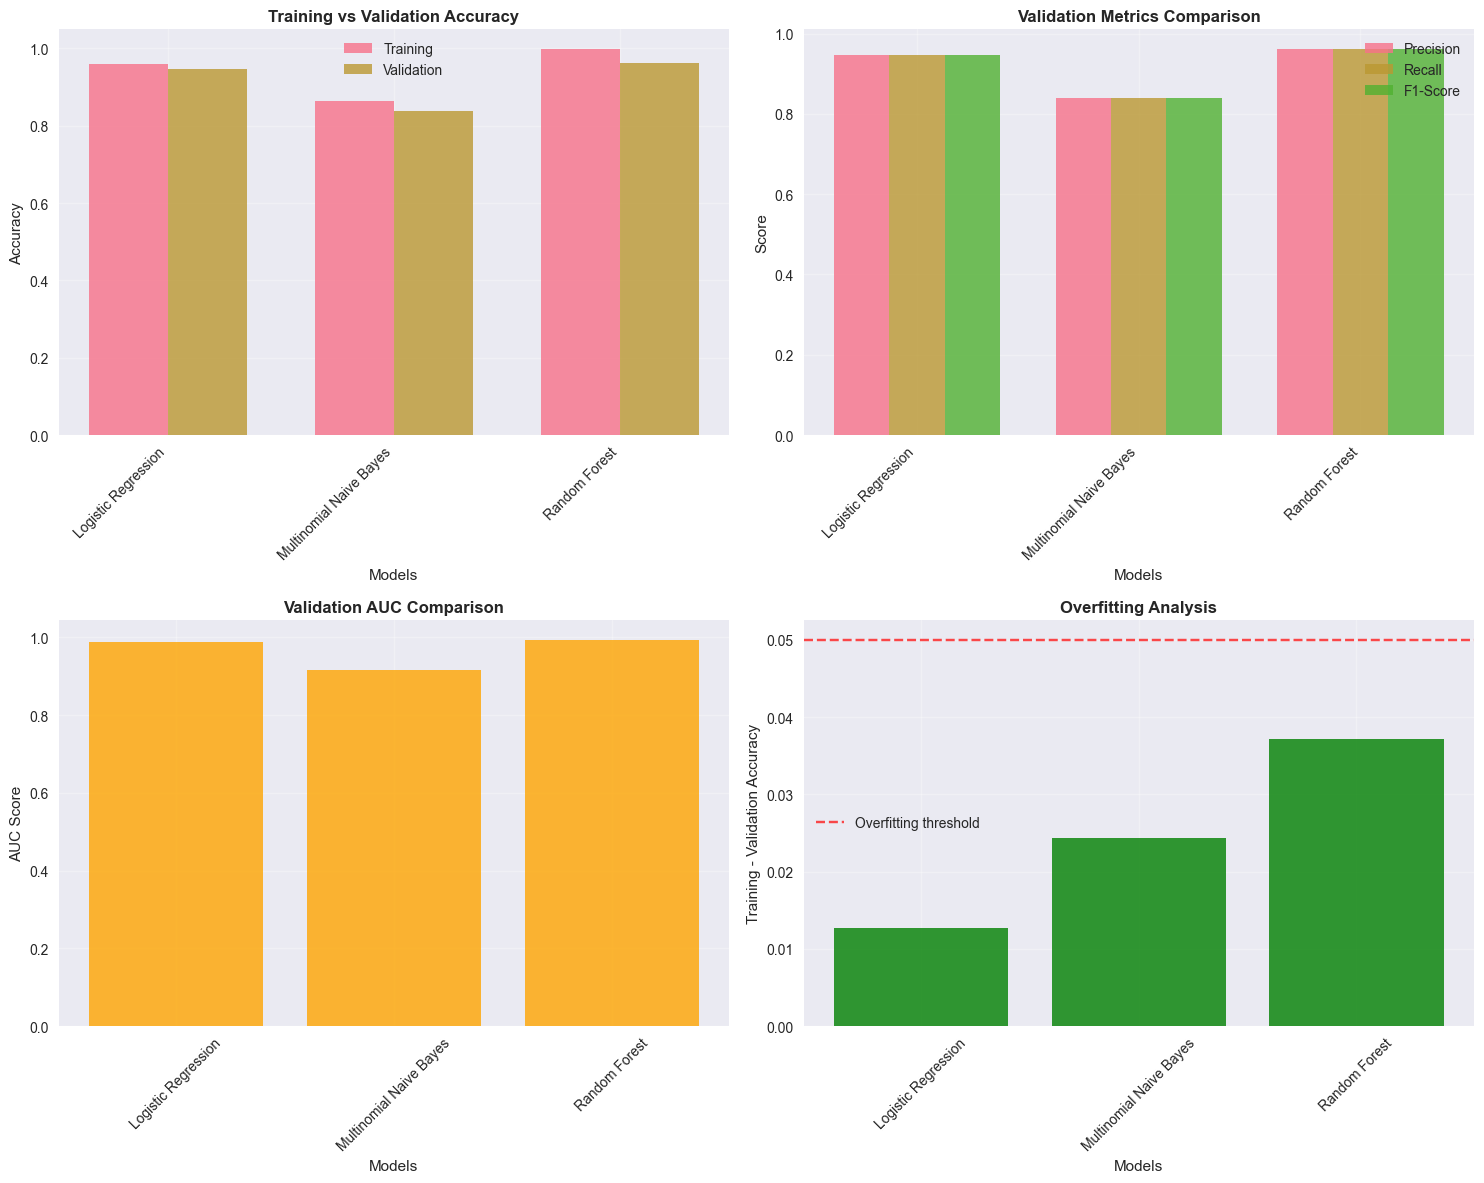


🔍 DETAILED ANALYSIS - Random Forest
----------------------------------------

📋 Classification Report:
              precision    recall  f1-score   support

       halal       0.96      0.98      0.97      2183
       haram       0.97      0.94      0.96      1796

    accuracy                           0.96      3979
   macro avg       0.96      0.96      0.96      3979
weighted avg       0.96      0.96      0.96      3979



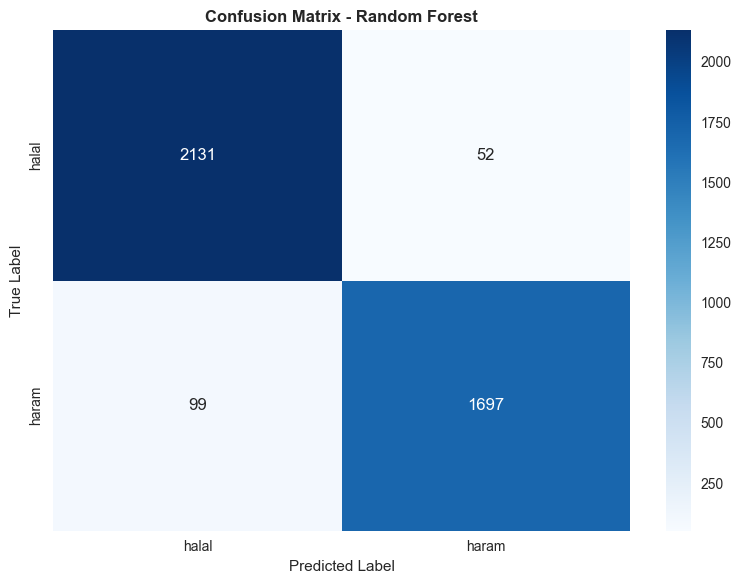


✅ Baseline models analysis selesai!


In [6]:
print("📈 PERBANDINGAN HASIL BASELINE MODELS")
print("=" * 50)

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("\n📊 Tabel Perbandingan Performa:")
display(results_df)

# Find best model berdasarkan validation F1-score
best_model_name = results_df['val_f1'].idxmax()
best_model = trained_models[best_model_name]
best_f1 = results_df.loc[best_model_name, 'val_f1']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"🎯 Best Validation F1-Score: {best_f1:.4f}")

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy comparison
models = list(results.keys())
train_accs = [results[model]['train_accuracy'] for model in models]
val_accs = [results[model]['val_accuracy'] for model in models]

x = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x - width/2, train_accs, width, label='Training', alpha=0.8)
axes[0, 0].bar(x + width/2, val_accs, width, label='Validation', alpha=0.8)
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Training vs Validation Accuracy', fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Validation metrics comparison
val_precisions = [results[model]['val_precision'] for model in models]
val_recalls = [results[model]['val_recall'] for model in models]
val_f1s = [results[model]['val_f1'] for model in models]

x = np.arange(len(models))
width = 0.25

axes[0, 1].bar(x - width, val_precisions, width, label='Precision', alpha=0.8)
axes[0, 1].bar(x, val_recalls, width, label='Recall', alpha=0.8)
axes[0, 1].bar(x + width, val_f1s, width, label='F1-Score', alpha=0.8)
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Validation Metrics Comparison', fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. AUC comparison (jika tersedia)
auc_scores = [results[model]['val_auc'] for model in models if results[model]['val_auc'] is not None]
auc_models = [model for model in models if results[model]['val_auc'] is not None]

if auc_scores:
    axes[1, 0].bar(auc_models, auc_scores, alpha=0.8, color='orange')
    axes[1, 0].set_xlabel('Models')
    axes[1, 0].set_ylabel('AUC Score')
    axes[1, 0].set_title('Validation AUC Comparison', fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'AUC scores not available', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('AUC Comparison - Not Available', fontweight='bold')

# 4. Overfitting analysis
overfitting = [train_accs[i] - val_accs[i] for i in range(len(models))]
colors = ['red' if x > 0.05 else 'green' for x in overfitting]

axes[1, 1].bar(models, overfitting, alpha=0.8, color=colors)
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Training - Validation Accuracy')
axes[1, 1].set_title('Overfitting Analysis', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Overfitting threshold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed analysis untuk best model
print(f"\n🔍 DETAILED ANALYSIS - {best_model_name}")
print("-" * 40)

# Predictions untuk detailed analysis
y_val_pred_best = best_model.predict(X_val_tfidf)

# Classification report
print("\n📋 Classification Report:")
target_names = label_encoder.classes_
print(classification_report(y_val, y_val_pred_best, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(f"\n✅ Baseline models analysis selesai!")

## 7. 🔍 Feature Importance Analysis
Menganalisis fitur (kata/n-gram) yang paling penting untuk klasifikasi.

🔍 FEATURE IMPORTANCE ANALYSIS
📊 Total features: 10000

🔍 Feature Importance - Random Forest

📈 Top 20 most important features:
   1. pork                 (importance:  0.038)
   2. potassium            (importance:  0.032)
   3. enzyme               (importance:  0.020)
   4. alcohol              (importance:  0.018)
   5. potassium sorbate    (importance:  0.015)
   6. yeast extract        (importance:  0.014)
   7. sorbate              (importance:  0.012)
   8. salt enzyme          (importance:  0.010)
   9. gelatin              (importance:  0.009)
  10. sauce water          (importance:  0.009)
  11. salt                 (importance:  0.009)
  12. culture salt         (importance:  0.008)
  13. phosphate            (importance:  0.008)
  14. sauce                (importance:  0.008)
  15. cheese               (importance:  0.008)
  16. sodium               (importance:  0.007)
  17. pork water           (importance:  0.007)
  18. cheese culture       (importance:  0.007)
  19. soy

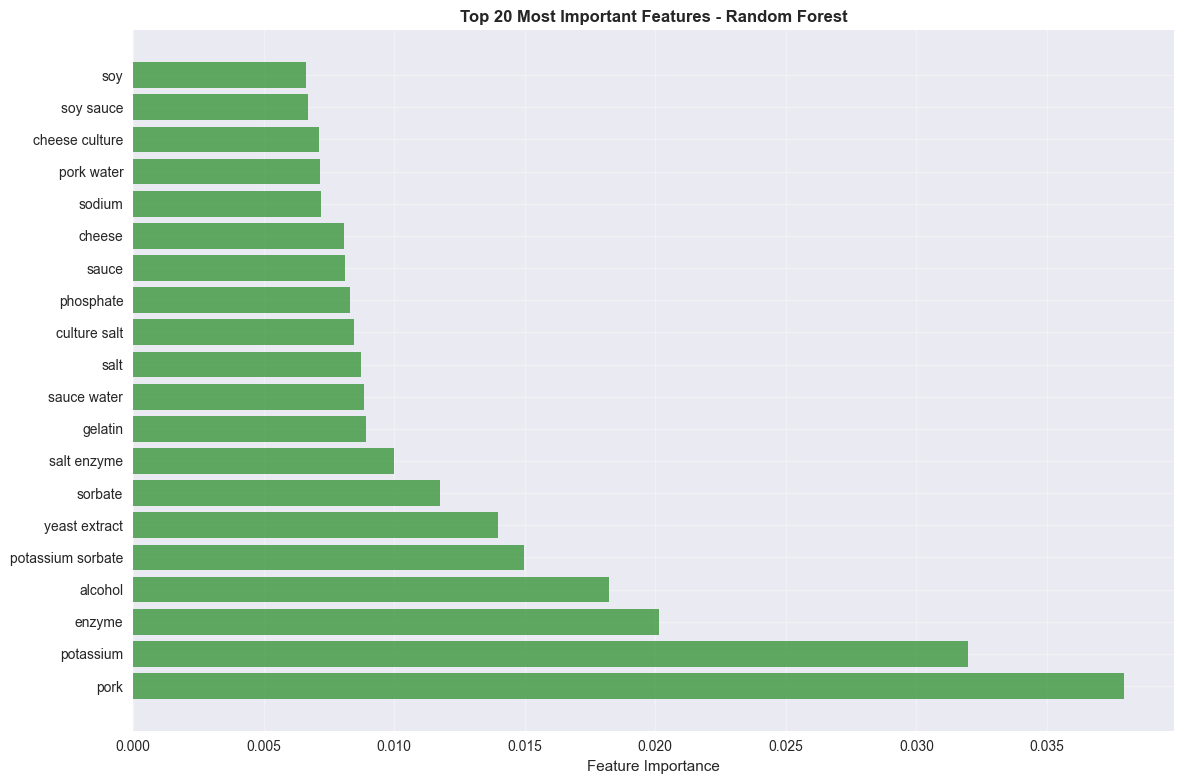


✅ Feature importance analysis selesai!


In [7]:
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"📊 Total features: {len(feature_names)}")

# Analisis untuk model yang mendukung feature importance
if best_model_name == 'Logistic Regression':
    # Untuk Logistic Regression, gunakan coefficients
    print(f"\n🔍 Feature Importance - {best_model_name}")
    
    # Get coefficients
    if len(label_encoder.classes_) == 2:  # Binary classification
        coefs = best_model.coef_[0]
    else:  # Multi-class
        # Untuk multi-class, ambil rata-rata absolute coefficients
        coefs = np.mean(np.abs(best_model.coef_), axis=0)
    
    # Get top positive dan negative features
    top_k = 20
    
    if len(label_encoder.classes_) == 2:
        # Binary: positive coef = class 1, negative coef = class 0
        top_positive_idx = np.argsort(coefs)[-top_k:]
        top_negative_idx = np.argsort(coefs)[:top_k]
        
        print(f"\n📈 Top {top_k} features untuk '{label_encoder.classes_[1]}':")
        for i, idx in enumerate(reversed(top_positive_idx), 1):
            print(f"  {i:2d}. {feature_names[idx]:20s} (coef: {coefs[idx]:6.3f})")
        
        print(f"\n📉 Top {top_k} features untuk '{label_encoder.classes_[0]}':")
        for i, idx in enumerate(top_negative_idx, 1):
            print(f"  {i:2d}. {feature_names[idx]:20s} (coef: {coefs[idx]:6.3f})")
        
        # Visualisasi
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # Positive features
        pos_features = [feature_names[idx] for idx in reversed(top_positive_idx)]
        pos_coefs = [coefs[idx] for idx in reversed(top_positive_idx)]
        
        axes[0].barh(range(len(pos_features)), pos_coefs, color='green', alpha=0.7)
        axes[0].set_yticks(range(len(pos_features)))
        axes[0].set_yticklabels(pos_features)
        axes[0].set_xlabel('Coefficient Value')
        axes[0].set_title(f'Top Features for \'{label_encoder.classes_[1]}\'', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Negative features
        neg_features = [feature_names[idx] for idx in top_negative_idx]
        neg_coefs = [coefs[idx] for idx in top_negative_idx]
        
        axes[1].barh(range(len(neg_features)), neg_coefs, color='red', alpha=0.7)
        axes[1].set_yticks(range(len(neg_features)))
        axes[1].set_yticklabels(neg_features)
        axes[1].set_xlabel('Coefficient Value')
        axes[1].set_title(f'Top Features for \'{label_encoder.classes_[0]}\'', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    else:
        # Multi-class: tampilkan top features berdasarkan importance
        top_idx = np.argsort(coefs)[-top_k:]
        
        print(f"\n📈 Top {top_k} most important features:")
        for i, idx in enumerate(reversed(top_idx), 1):
            print(f"  {i:2d}. {feature_names[idx]:20s} (importance: {coefs[idx]:6.3f})")
        
        # Visualisasi
        plt.figure(figsize=(12, 8))
        top_features = [feature_names[idx] for idx in reversed(top_idx)]
        top_importances = [coefs[idx] for idx in reversed(top_idx)]
        
        plt.barh(range(len(top_features)), top_importances, alpha=0.7)
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_k} Most Important Features - {best_model_name}', fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

elif best_model_name == 'Random Forest':
    # Untuk Random Forest, gunakan feature_importances_
    print(f"\n🔍 Feature Importance - {best_model_name}")
    
    importances = best_model.feature_importances_
    top_k = 20
    top_idx = np.argsort(importances)[-top_k:]
    
    print(f"\n📈 Top {top_k} most important features:")
    for i, idx in enumerate(reversed(top_idx), 1):
        print(f"  {i:2d}. {feature_names[idx]:20s} (importance: {importances[idx]:6.3f})")
    
    # Visualisasi
    plt.figure(figsize=(12, 8))
    top_features = [feature_names[idx] for idx in reversed(top_idx)]
    top_importances = [importances[idx] for idx in reversed(top_idx)]
    
    plt.barh(range(len(top_features)), top_importances, alpha=0.7, color='forestgreen')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_k} Most Important Features - {best_model_name}', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print(f"\n⚠️ Feature importance analysis tidak tersedia untuk {best_model_name}")
    
    # Alternative: analisis TF-IDF scores
    print(f"\n📊 Alternative: Top TF-IDF features analysis")
    
    # Hitung rata-rata TF-IDF score per class
    for class_idx, class_name in enumerate(label_encoder.classes_):
        class_mask = (y_val == class_idx)
        if np.sum(class_mask) > 0:
            class_tfidf = X_val_tfidf[class_mask]
            mean_tfidf = np.array(class_tfidf.mean(axis=0)).flatten()
            
            top_idx = np.argsort(mean_tfidf)[-10:]
            
            print(f"\n📋 Top 10 TF-IDF features untuk '{class_name}':")
            for i, idx in enumerate(reversed(top_idx), 1):
                print(f"  {i:2d}. {feature_names[idx]:20s} (avg TF-IDF: {mean_tfidf[idx]:6.3f})")

print(f"\n✅ Feature importance analysis selesai!")

## 8. 💾 Save Models dan Pipeline
Menyimpan model terbaik dan preprocessing pipeline untuk digunakan di notebook selanjutnya.

In [8]:
print("💾 SAVE MODELS DAN PIPELINE")
print("=" * 50)

# 1. Save TF-IDF Vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("✅ TF-IDF Vectorizer disimpan ke 'tfidf_vectorizer.pkl'")

# 2. Save best baseline model
joblib.dump(best_model, f'best_baseline_model_{best_model_name.lower().replace(" ", "_")}.pkl')
print(f"✅ Best baseline model ({best_model_name}) disimpan")

# 3. Save semua trained models
for model_name, model in trained_models.items():
    filename = f'baseline_{model_name.lower().replace(" ", "_").replace("(", "").replace(")", "")}.pkl'
    joblib.dump(model, filename)
    print(f"✅ {model_name} disimpan ke '{filename}'")

# 4. Create dan save complete pipeline untuk best model
best_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', best_model)
])

joblib.dump(best_pipeline, 'best_baseline_pipeline.pkl')
print(f"✅ Complete pipeline disimpan ke 'best_baseline_pipeline.pkl'")

# 5. Save baseline results dan metadata
baseline_metadata = {
    'best_model_name': best_model_name,
    'best_model_f1': float(best_f1),
    'all_results': {model: {k: float(v) if v is not None else None for k, v in metrics.items()} 
                   for model, metrics in results.items()},
    'tfidf_config': tfidf_config,
    'vocabulary_size': len(tfidf_vectorizer.vocabulary_),
    'feature_names': feature_names.tolist(),
    'preprocessing_config': {
        'lowercase': True,
        'remove_punctuation': True,
        'remove_numbers': False,
        'remove_stopwords': True,
        'apply_stemming': False,
        'apply_lemmatization': True,
        'min_word_length': 2
    },
    'label_encoder_classes': label_encoder.classes_.tolist(),
    'random_state': RANDOM_STATE
}

with open('baseline_metadata.json', 'w') as f:
    json.dump(baseline_metadata, f, indent=2)

print("✅ Baseline metadata disimpan ke 'baseline_metadata.json'")

# 6. Test saved pipeline
print(f"\n🧪 Testing saved pipeline...")
loaded_pipeline = joblib.load('best_baseline_pipeline.pkl')

# Test dengan beberapa sample
test_samples = X_val[:3]
original_predictions = best_pipeline.predict(test_samples)
loaded_predictions = loaded_pipeline.predict(test_samples)

if np.array_equal(original_predictions, loaded_predictions):
    print("✅ Pipeline berhasil disimpan dan dimuat dengan benar!")
else:
    print("❌ Ada masalah dengan pipeline yang disimpan!")

# 7. Summary file yang dihasilkan
generated_files = [
    'train.csv',
    'val.csv', 
    'test.csv',
    'split_metadata.json',
    'label_encoder.pkl',
    'tfidf_vectorizer.pkl',
    f'best_baseline_model_{best_model_name.lower().replace(" ", "_")}.pkl',
    'best_baseline_pipeline.pkl',
    'baseline_metadata.json'
]

# Tambahkan file model individual
for model_name in trained_models.keys():
    filename = f'baseline_{model_name.lower().replace(" ", "_").replace("(", "").replace(")", "")}.pkl'
    generated_files.append(filename)

print(f"\n📁 File yang dihasilkan dari notebook ini:")
for i, file in enumerate(generated_files, 1):
    print(f"  {i:2d}. {file}")

print(f"\n🎯 BASELINE BENCHMARK untuk Deep Learning Models:")
print(f"  Model: {best_model_name}")
print(f"  Validation Accuracy: {results[best_model_name]['val_accuracy']:.4f}")
print(f"  Validation F1-Score: {results[best_model_name]['val_f1']:.4f}")
print(f"  📊 Deep Learning models harus mengalahkan skor ini!")

print(f"\n✅ Preprocessing dan baseline modeling selesai!")
print(f"\n🚀 Lanjutkan ke notebook berikutnya: 03_Deep_Learning_Model_Experimentation.ipynb")

💾 SAVE MODELS DAN PIPELINE
✅ TF-IDF Vectorizer disimpan ke 'tfidf_vectorizer.pkl'
✅ Best baseline model (Random Forest) disimpan
✅ Logistic Regression disimpan ke 'baseline_logistic_regression.pkl'
✅ Multinomial Naive Bayes disimpan ke 'baseline_multinomial_naive_bayes.pkl'
✅ Random Forest disimpan ke 'baseline_random_forest.pkl'
✅ Complete pipeline disimpan ke 'best_baseline_pipeline.pkl'
✅ Baseline metadata disimpan ke 'baseline_metadata.json'

🧪 Testing saved pipeline...
✅ Pipeline berhasil disimpan dan dimuat dengan benar!

📁 File yang dihasilkan dari notebook ini:
   1. train.csv
   2. val.csv
   3. test.csv
   4. split_metadata.json
   5. label_encoder.pkl
   6. tfidf_vectorizer.pkl
   7. best_baseline_model_random_forest.pkl
   8. best_baseline_pipeline.pkl
   9. baseline_metadata.json
  10. baseline_logistic_regression.pkl
  11. baseline_multinomial_naive_bayes.pkl
  12. baseline_random_forest.pkl

🎯 BASELINE BENCHMARK untuk Deep Learning Models:
  Model: Random Forest
  Valida

## 🚀 Next Steps

Berdasarkan preprocessing dan baseline modeling di atas, langkah selanjutnya adalah:

1. **Deep Learning Experimentation** (Notebook 03):
   - Load data splits yang sudah dibuat (train.csv, val.csv, test.csv)
   - Implementasi Keras TextVectorization
   - Eksperimen dengan 3 arsitektur: 1D CNN, FastText/CBOW, LSTM/GRU
   - Target: mengalahkan baseline F1-score **{best_f1:.4f}**

2. **Model Selection** (Notebook 04):
   - Pilih model terbaik dari eksperimen
   - Evaluasi final pada test set
   - Export ke TensorFlow Lite untuk mobile deployment

---

**File yang dihasilkan dari notebook ini**:
- `train.csv`, `val.csv`, `test.csv` - Dataset splits
- `split_metadata.json` - Metadata untuk splits
- `label_encoder.pkl` - Label encoder
- `tfidf_vectorizer.pkl` - TF-IDF vectorizer
- `best_baseline_pipeline.pkl` - Complete baseline pipeline
- `baseline_metadata.json` - Baseline results dan konfigurasi
- Individual model files (`.pkl`)

**Baseline Benchmark yang harus dikalahkan**:
- **Model**: {best_model_name}
- **Validation Accuracy**: {results[best_model_name]['val_accuracy']:.4f}
- **Validation F1-Score**: {results[best_model_name]['val_f1']:.4f}

**Key Insights untuk Deep Learning**:
- Text preprocessing pipeline sudah optimal
- Dataset splits sudah stratified dan konsisten
- Vocabulary size: {len(tfidf_vectorizer.vocabulary_)} features
- Recommended max_length: {recommended_max_length} words
- Dataset balance: {'Balanced' if is_balanced else 'Imbalanced'}